### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default") 

### Define the split type and stock name


In [35]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
split = 1
stock = 1  # CMG

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


<Axes: >

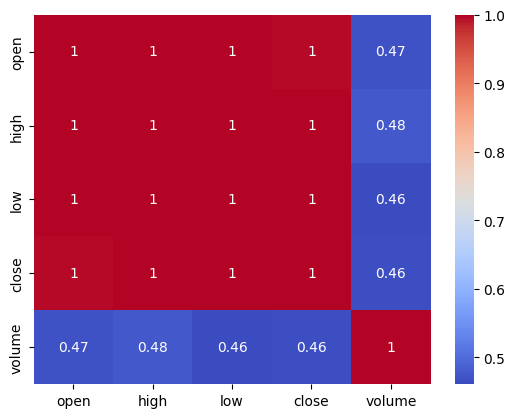

In [38]:
# Create a correlation matrix
df1 = df.drop(columns=["time", "ticker"], axis=1)
corr_matrix = df1.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Low price and close price are correlated => Good for forecast the "close price" in SARIMAX model

In [39]:
df = df[["low", "close"]] # Using low and close price to predict the next day close price, the low price is the exogenous variable

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


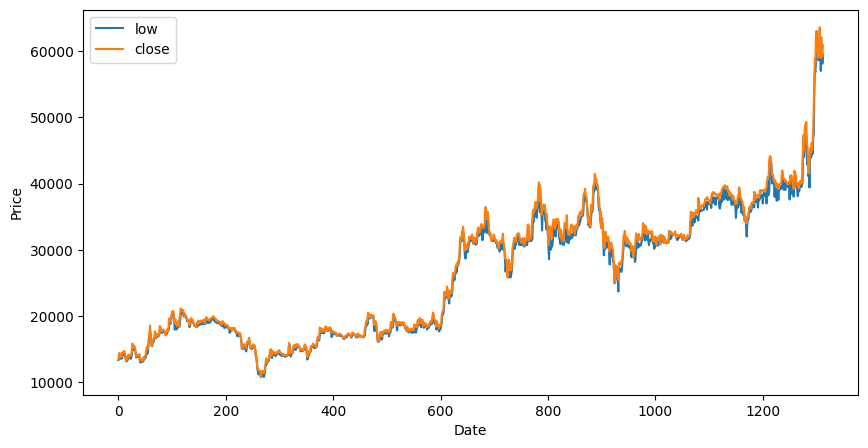

In [40]:
df.plot(figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [41]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [42]:
# Shape of the dataframe
df.shape

(1313, 2)

In [43]:
df.dtypes

low      int64
close    int64
dtype: object

In [44]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [45]:
# Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [46]:
# splitting data into train, test set
train_data = df[:train_size]
test_data = df[train_size:]

In [47]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

In [48]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963444,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [49]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [50]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.438
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.571
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


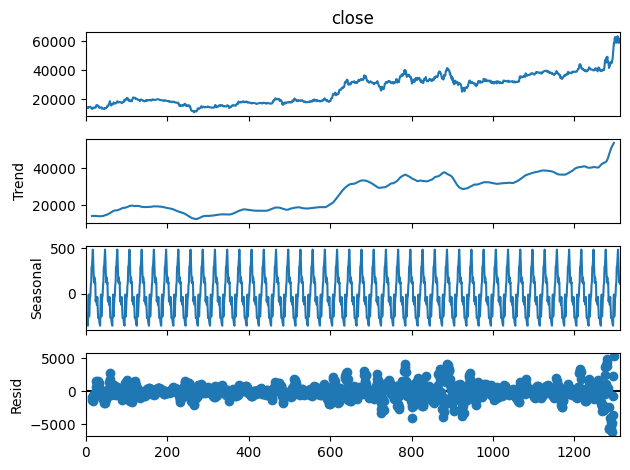

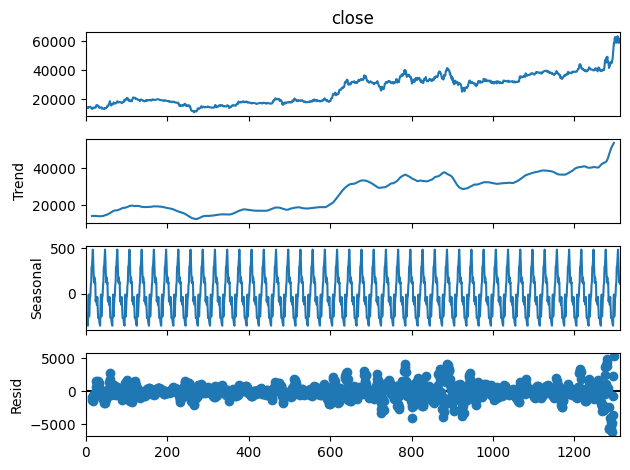

In [51]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [52]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [53]:
# Check again
adfuller(df_diff)

(-23.06833677840579,
 0.0,
 1,
 916,
 {'1%': -3.4375090829661534,
  '5%': -2.864700447588469,
  '10%': -2.5684528237924527},
 14059.177727416965)

The p-value is less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

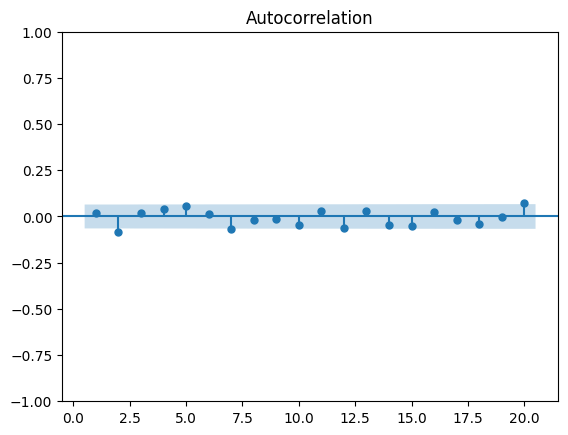

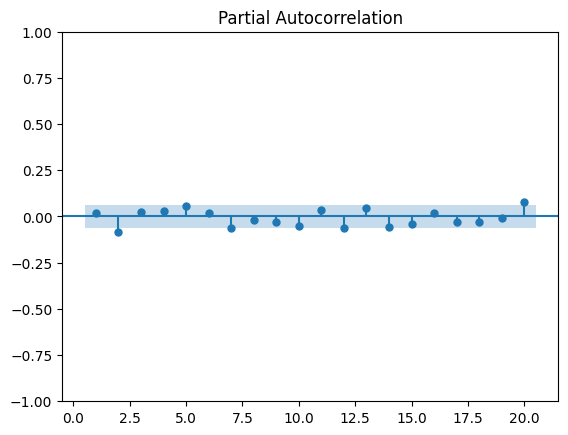

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [55]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [56]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14393.492, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14394.229, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14393.916, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14392.381, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=14392.532, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=14392.253, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=14393.860, Time=0.12 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=14393.059, Time=0.05 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=14394.679, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=14393.959, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=14394.016, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[5]             : AIC=14391.016, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[5]             : AIC=14392.658, Time=0.12 sec
 ARIMA(0,1,0)(0,0,2)[5]  

In [57]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -7193.508
Date:                             Thu, 20 Jun 2024   AIC                          14391.016
Time:                                     06:57:22   BIC                          14400.660
Sample:                                          0   HQIC                         14394.697
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5        0.0620      0.022      2.773      0.006       0.018       0.106
sigma2      3.748e+05   1.0

#### Use SARIMAX to train model


In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 0),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

### Test


In [59]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([30666.41768598, 30986.50953475, 30253.73733524, 30249.63487526,
       29621.79715451, 28734.15567284, 28771.92765078, 29475.43073998,
       29126.039944  , 29697.3411104 , 29012.72401017, 28974.95203223,
       28143.96851747, 29843.70752493, 29697.3411104 , 29772.88506629,
       29735.11308834, 29550.97469587, 29550.97469587, 29938.13746979,
       30471.66665824, 30896.60141011, 31434.8520958 , 31987.26727323,
       31543.44653239, 31987.26727323, 31618.99048828, 31359.30813992,
       31562.33252136, 31505.67455445, 31467.9025765 , 31359.30813992,
       31359.30813992, 31250.71370333, 31359.30813992, 31302.650173  ,
       30622.75457002, 30584.98259207, 31080.73980258, 31283.76418403,
       30584.98259207, 30622.75457002, 30806.89296249, 30249.75628782,
       30433.8946803 , 31359.30813992, 31212.94172538, 31803.12888075,
       31618.99048828, 31283.76418403, 31543.44653239, 31359.30813992,
       31467.9025765 , 31505.67455445, 31434.8520958 , 31656.76246622,
      

### Forecast the next 30/60/90 days


In [60]:
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Forecast closing prices for the next 30 days:")
print(y_30_days_pred)

Forecast closing prices for the next 30 days:
[36806.53263908 36802.5292192  36822.16312242 36829.19169802
 36840.44414617 36851.57518176 36862.70621735 36873.83725294
 36884.96828852 36896.09932411 36907.2303597  36918.36139529
 36929.49243087 36940.62346646 36951.75450205 36962.88553764
 36974.01657322 36985.14760881 36996.2786444  37007.40967998
 37018.54071557 37029.67175116 37040.80278675 37051.93382233
 37063.06485792 37074.19589351 37085.3269291  37096.45796468
 37107.58900027 37118.72003586]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"Forecast {stock_name[stock]} Stock Price Using SARIMAX")
    plt.legend()
    plt.show()

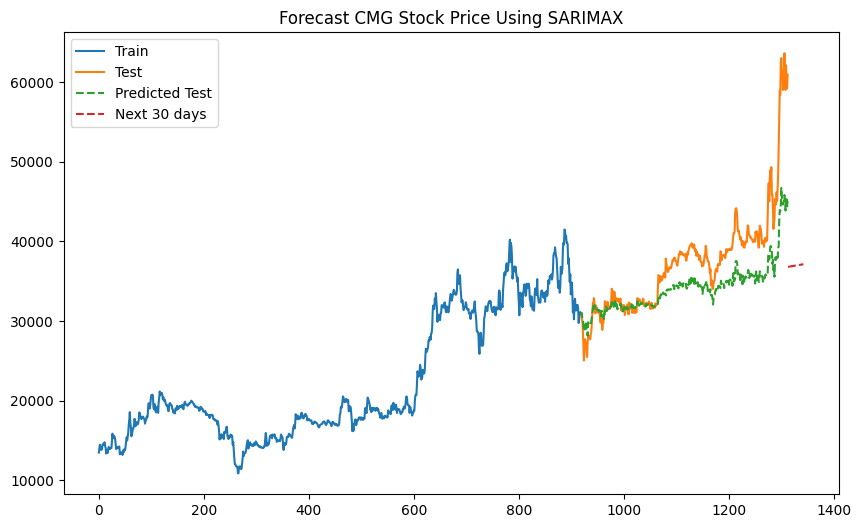

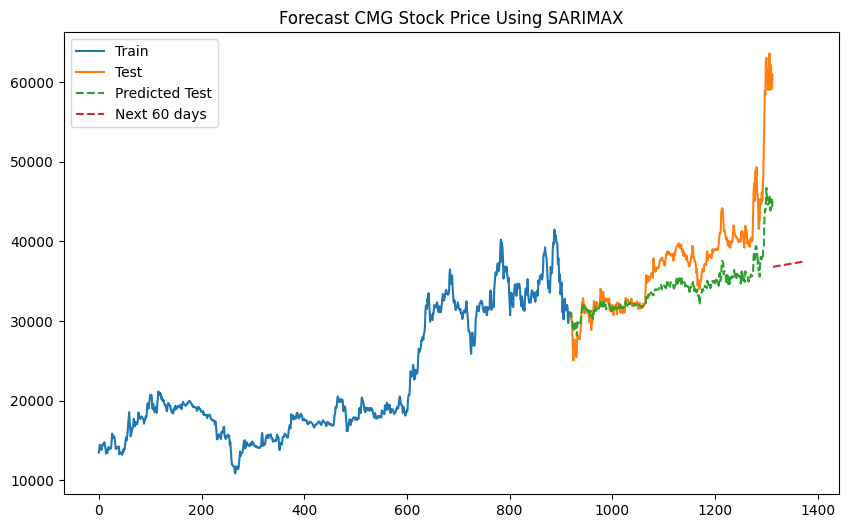

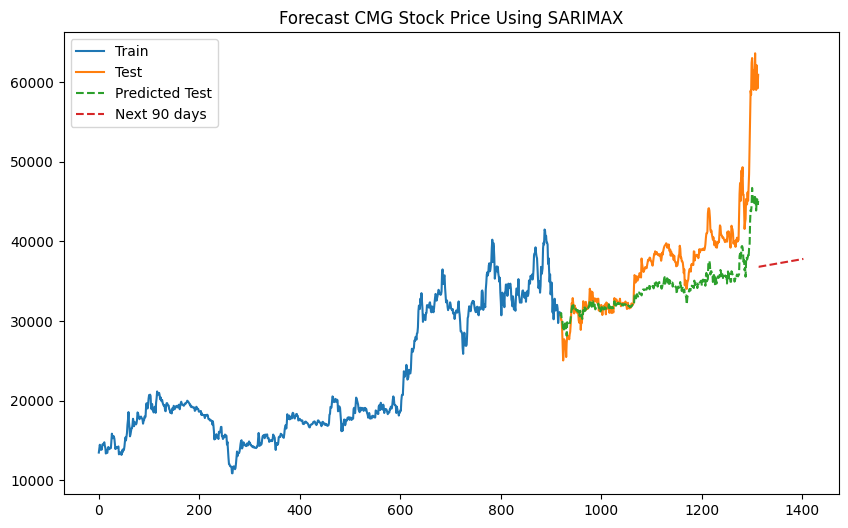

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE: {rmse(y_test, y_pred_test)}")
print(f"MAE: {mae(y_test, y_pred_test)}")
print(f"MAPE: {mape(y_test, y_pred_test) * 100} %")

RMSE: 4790.479722327112
MAE: 3368.2350010468163
MAPE: 8.027979030749876 %
